In [1]:
import kwant
import numpy as np 
import matplotlib.pyplot as plt

c:\Users\renar\anaconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
# Fundamental constants

pi = np.pi
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
vf = 1e6            # Fermi velocity (m/s)
hbar = h/(2*pi)     # Reduced planck constant

epsilon_0 = 8.85e-12  # Vacuum permittivity (F/m)
epsilon_hBN = 3
epsilon_Ox = 3.8

hbarvf = (3*np.sqrt(3)/8) * 1e-9 * e

## Physical Dimensions

In [39]:
s = 2
a = 1/(4*np.sqrt(3)) * s # nm, as in the article
t = 3 / s # 3 eV as in the article

# We want a square
W = 360
L = 360
W_leads = W
L_leads = 34

## Define the potential

In [40]:
# Definition of the onsite potential
db = 20e-9 # bottom hBN layer thickness (m)
dOx = 285e-9 # substrate thickness (m)

Cbg = epsilon_0 / (db/epsilon_hBN + dOx/epsilon_Ox)

# We do not have a precise function for the capacitance linked with the CNT, so we use the approximation they provide
r_cnt = 1e-9 # CNT radius (m)
dt = 4e-9 # top hBN thickness (m)
ht = dt + r_cnt
at = np.sqrt(ht**2 - r_cnt**2)
kappa = (ht+at)**2/r_cnt**2

# Here, epsilon_r is set to have a curve resembling the simulation in the article (Ccnt/e evaluated at 0 is around 2.5e12 cm^-2 V^-1)
def computeCcnt(x, epsilon_r=2.5):
    return epsilon_0*epsilon_r*4*at/((x**2+at**2)*np.log(kappa))

def potential(site, Vcnt, Vbg):
    (x, y) = site.pos
    Ccnt = computeCcnt(np.abs(x)*1e-9)
    n = (Cbg*Vbg + Ccnt*Vcnt)/e
    U = -np.sign(n)*hbarvf*np.sqrt(pi*np.abs(n))
    return U/e # Divide by e to obtain electronVolts

## Create the system 

In [41]:
def rect(pos):
    x, y = pos
    if -L/2 < x < L/2 and -W/2 < y < W/2:
        return True
    else:
        return False 
    
def verticalLeads(pos):
    x, y = pos
    if -W_leads/2 < y < W_leads/2:
        return True
    else:
        return False 
    
def horizontalLeads(pos):
    x, y = pos
    if -L_leads/2 < x < L_leads/2:
        return True
    else:
        return False 
    
def antireflLeads(pos):
    x, y = pos
    if -L/2 < x < L/2:
        return True
    else:
        return False 

def system_maker():
    # Build scattering region
    lattice = kwant.lattice.general([(np.sqrt(3)*a, 0), (0, 3*a)], [(a*np.sqrt(3)/2, 0), (0, a/2), (0, 3*a/2)\
                                                                     , (a*np.sqrt(3)/2, 2*a)], norbs = 1)
    A, B, C, D = lattice.sublattices
    sys = kwant.Builder()
    hoppings = (((0, 0), B, A), ((0, 0), C, B), ((0, 0), D, C), ((-1, 0), A, B), ((-1, 0), D, C),((0, 1), A, D))
    sys[lattice.shape(rect, (0,0))] = potential
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t
    sys.eradicate_dangling()

    # Build top and bottom leads (where we measure conductance)
    sym1 = kwant.TranslationalSymmetry(lattice.vec((0, 1)))
    lead1 = kwant.Builder(sym1)
    lead1[lattice.shape(horizontalLeads, (0, 0))] = potential
    lead1[lattice.neighbors()]= -t
    lead1.eradicate_dangling()
    sys.attach_lead(lead1)
    sys.attach_lead(lead1.reversed())

    # Build left and right leads (leakage)
    sym2 = kwant.TranslationalSymmetry(lattice.vec((-1, 0)))
    lead2 = kwant.Builder(sym2)
    lead2[lattice.shape(verticalLeads, (0, 0))] = potential
    lead2[lattice.neighbors()]= -t
    lead2.eradicate_dangling()
    sys.attach_lead(lead2)
    sys.attach_lead(lead2.reversed())

    # # Build left and right leads (leakage)
    # sym3 = kwant.TranslationalSymmetry(lattice.vec((0, 1)))
    # lead3 = kwant.Builder(sym3)
    # lead3[lattice.shape(antireflLeads, (0, 0))] = potential
    # lead3[lattice.neighbors()]= -t
    # lead3.eradicate_dangling()
    # sys.attach_lead(lead3)
    # sys.attach_lead(lead3.reversed())
    
    return sys  

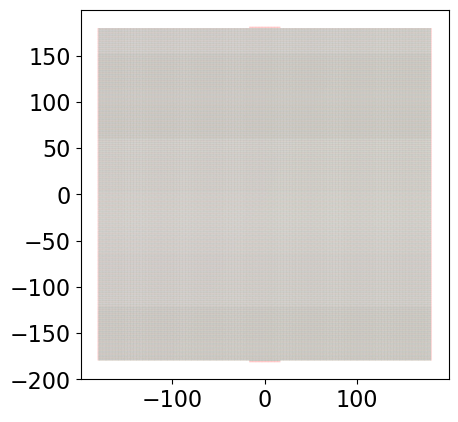

In [42]:
plot = True

sys = system_maker()

if plot:
    kwant.plot(sys)

fsyst = sys.finalized()

C:\Users\renar\AppData\Local\Temp\ipykernel_20692\210578141.py:7: RuntimeWarning: The plotted data contains 1.56% of values underflowing lower limit -0.342164 
  kwant.plotter.map(fsyst, lambda i: fsyst.hamiltonian(i, i, params=params), cmap='viridis')


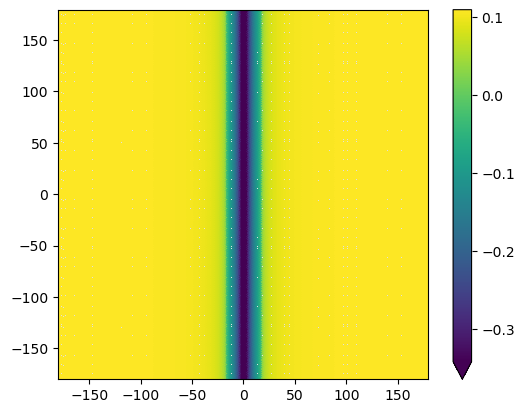

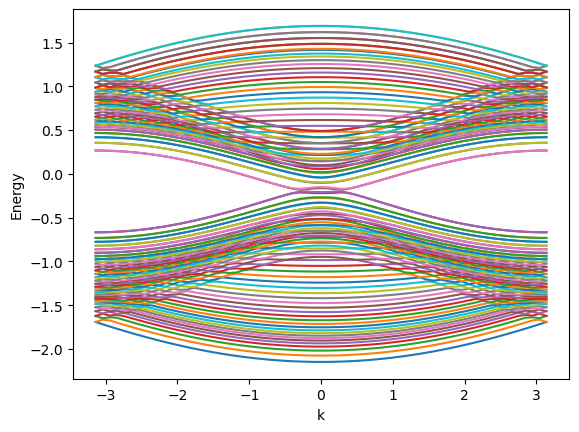

In [7]:
# Displays Hamiltonian (onsite energy) and bandstructure of the leads
plot=True

params=dict(Vcnt=5, Vbg=-13.5)

if plot:
    kwant.plotter.map(fsyst, lambda i: fsyst.hamiltonian(i, i, params=params), cmap='viridis')
    kwant.plotter.bands(fsyst.leads[0], params=params)

In [377]:
# Computes conductance
Ef = 0
VcnArray = np.linspace(0, 15, 30)

def computeTransmission(Ef, params):
    smatrix = kwant.smatrix(fsyst, Ef, params=params)
    return smatrix.transmission(1, 0)

T = np.zeros_like(VcnArray)
for i in range(len(VcnArray)):
    T[i] = computeTransmission(Ef, dict(Vcnt=VcnArray[i], Vbg=-13.5))
    print(i)

plt.plot(VcnArray, T)
plt.grid()
plt.xlabel(r"$V_{\text{cnt}}$ (V)")
plt.ylabel(r"$G$ ($e^2/h$)")
plt.show()

KeyboardInterrupt: 

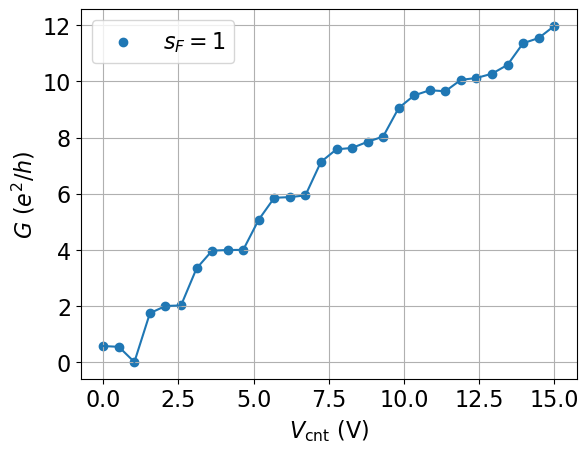

In [43]:
# np.save("Vcnt0to15sF1.npy", T)
VcnArray = np.linspace(0, 15, 30)
T = np.load("Vcnt0to15sF2.npy")

plt.rcParams.update({'font.size': 16})
plt.plot(VcnArray, T)
plt.scatter(VcnArray, T, label=r"$s_F = 1$")
plt.grid()
plt.legend()
plt.xlabel(r"$V_{\text{cnt}}$ (V)")
plt.ylabel(r"$G$ ($e^2/h$)")
plt.show()

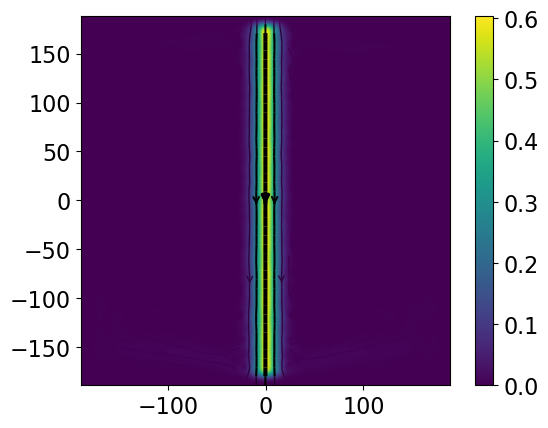

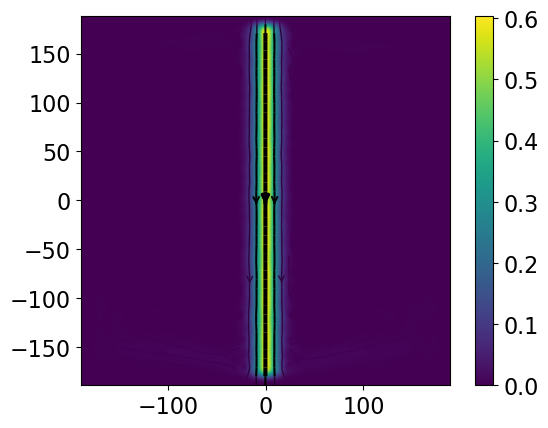

In [44]:
Ef = 0
params = dict(Vcnt=16, Vbg=-13.5)

wfs = kwant.wave_function(fsyst, Ef, params=params)
J = kwant.operator.Current(fsyst)

wf = wfs(0) # in top lead

current = sum(J(mode) for mode in wf)

kwant.plotter.current(fsyst, current, cmap='viridis')

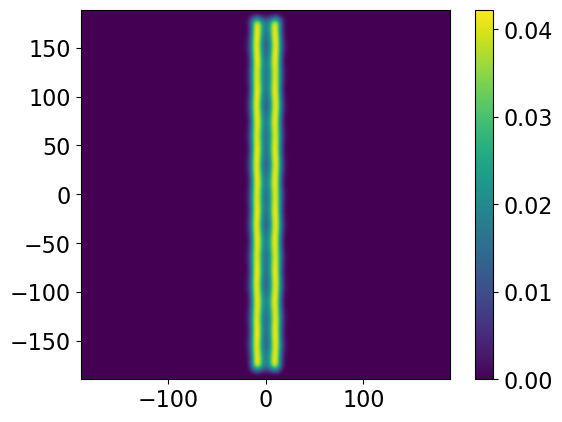

C:\Users\renar\AppData\Local\Temp\ipykernel_20692\3358896638.py:2: RuntimeWarning: invalid value encountered in divide
  kwant.plotter.current(fsyst, current, cmap='viridis', max_linewidth=0, min_linewidth=0)


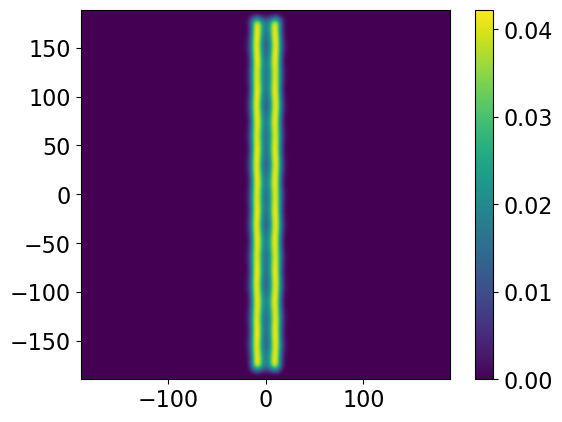

In [52]:
current = J(wf[-5])
kwant.plotter.current(fsyst, current, cmap='viridis', max_linewidth=0, min_linewidth=0)

C:\Users\renar\AppData\Local\Temp\ipykernel_10916\256594150.py:4: RuntimeWarning: The plotted data contains 1.93% of values overflowing upper limit 0.00773842 
  kwant.plotter.map(fsyst, abs(scattering_wf)**2) # to map the wave function


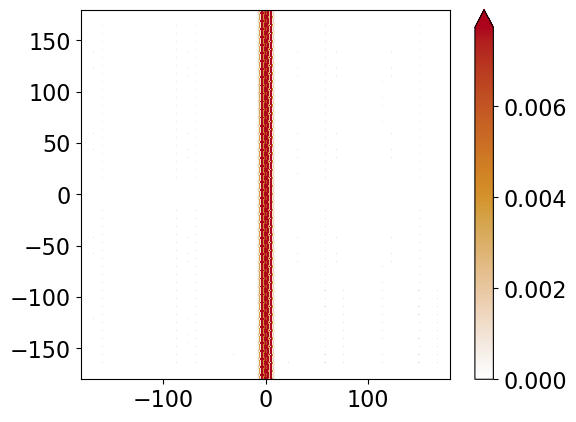

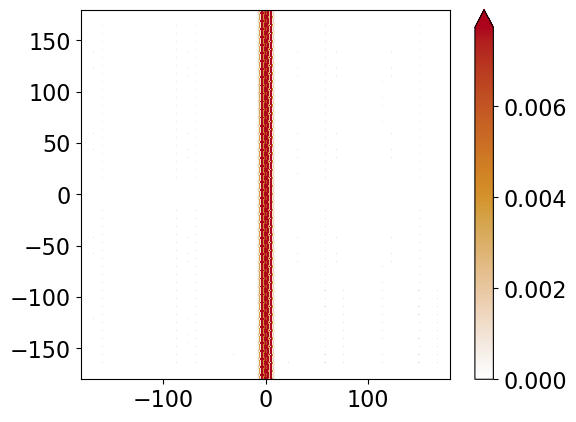

In [ ]:
mode = 2
scattering_wf = wfs(0)[mode]

kwant.plotter.map(fsyst, abs(scattering_wf)**2) # to map the wave function
